# Importações

In [1]:
from time import time 
import os
import numpy as np  
import pandas as pd
from statistics import mean, stdev 
from typing import List
import docplex.mp.model as mp
from docplex.mp.constr import LinearConstraint
import tensorflow as tf
import cplex
from cplex import infinity 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Milp

## Fischetti

### Original

In [2]:
def codify_network_fischetti(
    mdl,
    layers,
    input_variables,
    auxiliary_variables,
    intermediate_variables,
    decision_variables,
    output_variables,
):
    output_bounds = []
    bounds = []

    for i in range(len(layers)):
        A = layers[i].get_weights()[0].T
        b = layers[i].bias.numpy()
        x = input_variables if i == 0 else intermediate_variables[i - 1]
        if i != len(layers) - 1:
            s = auxiliary_variables[i]
            a = decision_variables[i]
            y = intermediate_variables[i]
        else:
            y = output_variables

        for j in range(A.shape[0]):
            if i != len(layers) - 1:
                mdl.add_constraint(
                    A[j, :] @ x + b[j] == y[j] - s[j], ctname=f"c_{i}_{j}"
                )
                mdl.add_indicator(a[j], y[j] <= 0, 1)
                mdl.add_indicator(a[j], s[j] <= 0, 0)

                mdl.maximize(y[j])
                mdl.solve()
                ub_y = mdl.solution.get_objective_value()
                mdl.remove_objective()

                mdl.maximize(s[j])
                mdl.solve()
                ub_s = mdl.solution.get_objective_value()
                mdl.remove_objective()

                y[j].set_ub(ub_y)
                s[j].set_ub(ub_s)

                bounds.append([-ub_s, ub_y])

            else:
                mdl.add_constraint(A[j, :] @ x + b[j] ==
                                   y[j], ctname=f"c_{i}_{j}")
                mdl.maximize(y[j])
                mdl.solve()
                ub = mdl.solution.get_objective_value()
                mdl.remove_objective()

                mdl.minimize(y[j])
                mdl.solve()
                lb = mdl.solution.get_objective_value()
                mdl.remove_objective()

                y[j].set_ub(ub)
                y[j].set_lb(lb)
                output_bounds.append([lb, ub])

                bounds.append([lb, ub])

    return mdl, output_bounds, bounds

### Relaxado

In [3]:
def codify_network_fischetti_relaxed(
    mdl,
    layers,
    input_variables,
    auxiliary_variables,
    intermediate_variables,
    decision_variables,
    output_variables,
    output_bounds_binary_variables,
    bounds=[]
):
    output_bounds = []

    for i in range(len(layers)):  # para cada camada
        A = layers[i].get_weights()[0].T
        b = layers[i].bias.numpy()
        x = input_variables if i == 0 else intermediate_variables[i - 1]
        if i != len(layers) - 1:
            s = auxiliary_variables[i]
            a = decision_variables[i]
            y = intermediate_variables[i]
        else:
            y = output_variables

        for j in range(A.shape[0]):  # para cada neuronio da camada
            if i != len(layers) - 1:  # se não for a última camada(camada de saída)
                m_less, m_more = bounds[j]

                y[j].set_ub(-m_less)
                s[j].set_ub(m_more)
                if m_more <= 0:
                    mdl.add_constraint(y[j] == 0)
                    continue

                if m_less >= 0:
                    mdl.add_constraint(A[j, :] @ x + b[j] == y[j])
                    continue

                if m_less < 0 and m_more > 0:
                    mdl.add_constraint(
                        A[j, :] @ x + b[j] == y[j] - s[j], ctname=f"c_{i}_{j}"
                    )
                    mdl.add_constraint(y[j] <= m_more * (1 - a[j]))
                    mdl.add_constraint(s[j] <= -m_less * a[j])
                    continue

            else:
                lb, ub = output_bounds_binary_variables[j]
                y[j].set_lb(lb)
                y[j].set_ub(ub)
                output_bounds.append([lb, ub])

    return mdl, output_bounds

## Tjeng

In [4]:
def codify_network_tjeng(
    mdl,
    layers,
    input_variables,
    intermediate_variables,
    decision_variables,
    output_variables,
):
    output_bounds = []

    for i in range(len(layers)):
        A = layers[i].get_weights()[0].T
        b = layers[i].bias.numpy()
        x = input_variables if i == 0 else intermediate_variables[i - 1]
        if i != len(layers) - 1:
            a = decision_variables[i]
            y = intermediate_variables[i]
        else:
            y = output_variables

        for j in range(A.shape[0]):
            mdl.maximize(A[j, :] @ x + b[j])
            mdl.solve()
            ub = mdl.solution.get_objective_value()
            mdl.remove_objective()

            if ub <= 0 and i != len(layers) - 1:
                # print("ENTROU, o ub é negativo, logo y = 0")
                mdl.add_constraint(y[j] == 0, ctname=f"c_{i}_{j}")
                continue

            mdl.minimize(A[j, :] @ x + b[j])
            mdl.solve()
            lb = mdl.solution.get_objective_value()
            mdl.remove_objective()

            if lb >= 0 and i != len(layers) - 1:
                # print("ENTROU, o lb >= 0, logo y = Wx + b")
                mdl.add_constraint(A[j, :] @ x + b[j] ==
                                   y[j], ctname=f"c_{i}_{j}")
                continue

            if i != len(layers) - 1:
                mdl.add_constraint(y[j] <= A[j, :] @ x +
                                   b[j] - lb * (1 - a[j]))
                mdl.add_constraint(y[j] >= A[j, :] @ x + b[j])
                mdl.add_constraint(y[j] <= ub * a[j])

                # mdl.maximize(y[j])
                # mdl.solve()
                # ub_y = mdl.solution.get_objective_value()
                # mdl.remove_objective()
                # y[j].set_ub(ub_y)

            else:
                mdl.add_constraint(A[j, :] @ x + b[j] == y[j])
                # y[j].set_ub(ub)
                # y[j].set_lb(lb)
                output_bounds.append([lb, ub])

    return mdl, output_bounds

## Domain and Bounds

In [5]:
def get_domain_and_bounds_inputs(dataframe):
    domain = []
    bounds = []
    for column in dataframe.columns[:-1]:
        if len(dataframe[column].unique()) == 2:
            domain.append("B")
            bound_inf = dataframe[column].min()
            bound_sup = dataframe[column].max()
            bounds.append([bound_inf, bound_sup])
        elif np.any(
            dataframe[column].unique().astype(np.int64)
            != dataframe[column].unique().astype(np.float64)
        ):
            domain.append("C")
            bound_inf = dataframe[column].min()
            bound_sup = dataframe[column].max()
            bounds.append([bound_inf, bound_sup])
        else:
            domain.append("I")
            bound_inf = dataframe[column].min()
            bound_sup = dataframe[column].max()
            bounds.append([bound_inf, bound_sup])

    return domain, bounds

## Codify Network

**X ---- E**

x1 = 1 ∧ x2 = 3 ∧ F ∧ ¬E  
*INSATISFÁTIVEL*

x1 ≥ 0 ∧ x1 ≤ 100 ∧ x2 = 3 ∧ F ∧ ¬E  
*INSATISFÁTIVEL* → x1 não é relevante,  
*SATISFATÍVEL* → x1 é relevante


### Original

In [6]:
def codify_network(model, dataframe, method, relaxe_constraints):
    layers = model.layers
    num_features = layers[0].get_weights()[0].shape[0]
    mdl = mp.Model()

    domain_input, bounds_input = get_domain_and_bounds_inputs(dataframe)
    bounds_input = np.array(bounds_input)

    if relaxe_constraints:
        input_variables = mdl.continuous_var_list(
            num_features, lb=bounds_input[:,
                                          0], ub=bounds_input[:, 1], name="x"
        )
    else:
        input_variables = []
        for i in range(len(domain_input)):
            lb, ub = bounds_input[i]
            if domain_input[i] == "C":
                input_variables.append(
                    mdl.continuous_var(lb=lb, ub=ub, name=f"x_{i}"))
            elif domain_input[i] == "I":
                input_variables.append(
                    mdl.integer_var(lb=lb, ub=ub, name=f"x_{i}"))
            elif domain_input[i] == "B":
                input_variables.append(mdl.binary_var(name=f"x_{i}"))

    intermediate_variables = []
    auxiliary_variables = []
    decision_variables = []

    for i in range(len(layers) - 1):
        weights = layers[i].get_weights()[0]
        intermediate_variables.append(
            mdl.continuous_var_list(
                weights.shape[1], lb=0, name="y", key_format=f"_{i}_%s"
            )
        )

        if method == "fischetti":
            auxiliary_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], lb=0, name="s", key_format=f"_{i}_%s"
                )
            )

        if relaxe_constraints and method == "tjeng":
            decision_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )
        else:
            decision_variables.append(
                mdl.binary_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )

    output_variables = mdl.continuous_var_list(
        layers[-1].get_weights()[0].shape[1], lb=-infinity, name="o"
    )

    if method == "tjeng":
        mdl, output_bounds = codify_network_tjeng(
            mdl,
            layers,
            input_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
        )
    else:
        mdl, output_bounds, bounds = codify_network_fischetti(
            mdl,
            layers,
            input_variables,
            auxiliary_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
        )

    if relaxe_constraints:
        # Tighten domain of variables 'a'
        for i in decision_variables:
            for a in i:
                a.set_vartype("Integer")

        # Tighten domain of input variables
        for i, x in enumerate(input_variables):
            if domain_input[i] == "I":
                x.set_vartype("Integer")
            elif domain_input[i] == "B":
                x.set_vartype("Binary")
            elif domain_input[i] == "C":
                x.set_vartype("Continuous")

    return mdl, output_bounds, bounds


### Relaxado

In [7]:
def codify_network_relaxed(
    model, dataframe, method, relaxe_constraints, output_bounds_binary_variables, bounds
):
    layers = model.layers
    num_features = layers[0].get_weights()[0].shape[0]
    mdl = mp.Model()

    domain_input, bounds_input = get_domain_and_bounds_inputs(dataframe)
    bounds_input = np.array(bounds_input)

    if relaxe_constraints:
        input_variables = mdl.continuous_var_list(
            num_features, lb=bounds_input[:,
                                          0], ub=bounds_input[:, 1], name="x"
        )
    else:
        input_variables = []
        for i in range(len(domain_input)):
            lb, ub = bounds_input[i]
            input_variables.append(
                mdl.continuous_var(lb=lb, ub=ub, name=f"x_{i}"))
            # if domain_input[i] == "C":
            #     input_variables.append(mdl.continuous_var(lb=lb, ub=ub, name=f"x_{i}"))
            # elif domain_input[i] == "I":
            #     input_variables.append(mdl.integer_var(lb=lb, ub=ub, name=f"x_{i}"))
            # elif domain_input[i] == "B":
            #     input_variables.append(mdl.binary_var(name=f"x_{i}"))

    intermediate_variables = []
    auxiliary_variables = []
    decision_variables = []

    for i in range(len(layers) - 1):
        weights = layers[i].get_weights()[0]
        intermediate_variables.append(
            mdl.continuous_var_list(
                weights.shape[1], lb=0, name="y", key_format=f"_{i}_%s"
            )
        )

        if method == "fischetti":
            auxiliary_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], lb=0, name="s", key_format=f"_{i}_%s"
                )
            )

        if relaxe_constraints and method == "tjeng":
            decision_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )
        else:
            # decision_variables.append(mdl.binary_var_list(weights.shape[1], name='a', lb=0, ub=1, key_format=f"_{i}_%s"))
            decision_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )

    output_variables = mdl.continuous_var_list(
        layers[-1].get_weights()[0].shape[1], lb=-infinity, name="o"
    )

    if method == "tjeng":
        # modificar depois para utilizar bounds precisos
        mdl, output_bounds = codify_network_tjeng(
            mdl,
            layers,
            input_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
        )
    else:
        # mdl, output_bounds = codify_network_fischetti(mdl, layers, input_variables, auxiliary_variables, intermediate_variables, decision_variables, output_variables)
        mdl, output_bounds = codify_network_fischetti_relaxed(
            mdl,
            layers,
            input_variables,
            auxiliary_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
            output_bounds_binary_variables,
            bounds=bounds
        )

    if relaxe_constraints:
        # Tighten domain of variables 'a'
        for i in decision_variables:
            for a in i:
                # a.set_vartype('Integer')
                a.set_vartype("Continuous")

        # Tighten domain of input variables
        for i, x in enumerate(input_variables):
            x.set_vartype("Continuous")
            # if domain_input[i] == "I":
            #     x.set_vartype("Integer")
            # elif domain_input[i] == "B":
            #     x.set_vartype("Binary")
            # elif domain_input[i] == "C":
            #     x.set_vartype("Continuous")

    return mdl, output_bounds


# Teste

## Insert Outputs

In [8]:
def insert_output_constraints_fischetti(
    mdl, output_variables, network_output, binary_variables
):
    # print(binary_variables)
    variable_output = output_variables[network_output]
    aux_var = 0

    for i, output in enumerate(output_variables):
        if i != network_output:
            p = binary_variables[aux_var]
            aux_var += 1
            mdl.add_indicator(p, variable_output <= output, 1)

    return mdl

def insert_output_constraints_tjeng(
    mdl, output_variables, network_output, binary_variables, output_bounds
):
    variable_output = output_variables[network_output]
    upper_bounds_diffs = (
        output_bounds[network_output][1] - np.array(output_bounds)[:, 0]
    )  # Output i: oi - oj <= u1 = ui - lj
    aux_var = 0

    for i, output in enumerate(output_variables):
        if i != network_output:
            ub = upper_bounds_diffs[i]
            z = binary_variables[aux_var]
            mdl.add_constraint(variable_output - output - ub * (1 - z) <= 0)
            aux_var += 1

    return mdl


## Explicações

### Original

In [9]:
def get_minimal_explanation(
    mdl,
    network_input,
    network_output,
    n_classes,
    method,
    output_bounds=None,
    initial_explanation=None,
) -> List[LinearConstraint]:
    assert not (
        method == "tjeng" and output_bounds == None
    ), "If the method tjeng is chosen, output_bounds must be passed."

    output_variables = [mdl.get_var_by_name(f"o_{i}") for i in range(n_classes)]

    if initial_explanation is None:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == feature.numpy()
                for i, feature in enumerate(network_input[0])
            ],
            names="input",
        )
    else:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == network_input[0][i].numpy()
                for i in initial_explanation
            ],
            names="input",
        )

    binary_variables = mdl.binary_var_list(n_classes - 1, name="b")
    mdl.add_constraint(mdl.sum(binary_variables) >= 1)
    # todo: salvar modelo durante a explicação

    if method == "tjeng":
        mdl = insert_output_constraints_tjeng(
            mdl, output_variables, network_output, binary_variables, output_bounds
        )
    else:
        mdl = insert_output_constraints_fischetti(
            mdl, output_variables, network_output, binary_variables
        )

    for constraint in input_constraints:
        mdl.remove_constraint(constraint)

        mdl.solve(log_output=False)
        if mdl.solution is not None:
            mdl.add_constraint(constraint)

    return mdl.find_matching_linear_constraints("input")


### Relaxado

In [10]:
def get_explanation_relaxed(
    mdl,
    network_input,
    network_output,
    n_classes,
    method,
    output_bounds=None,
    initial_explanation=None,
    delta=0.1,
) -> List[LinearConstraint]:
    # todo: output_bounds só é relevante se o metodo for tjeng
    assert not (
        method == "tjeng" and output_bounds == None
    ), "If the method tjeng is chosen, output_bounds must be passed."

    output_variables = [mdl.get_var_by_name(f"o_{i}") for i in range(n_classes)]

    if initial_explanation is None:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == feature.numpy()
                for i, feature in enumerate(network_input[0])
            ],
            names="input",
        )
    else:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == network_input[0][i].numpy()
                for i in initial_explanation
            ],
            names="input",
        )

    binary_variables = mdl.binary_var_list(n_classes - 1, name="b")
    mdl.add_constraint(mdl.sum(binary_variables) >= 1)
    # todo: salvar modelo durante a explicação

    if method == "tjeng":
        mdl = insert_output_constraints_tjeng(
            mdl, output_variables, network_output, binary_variables, output_bounds
        )
    
    else:
        mdl = insert_output_constraints_fischetti(
            mdl, output_variables, network_output, binary_variables
        )

    for constraint in input_constraints:
        mdl.remove_constraint(constraint)

        x = constraint.get_left_expr()
        v = constraint.get_right_expr()

        constraint_left = mdl.add_constraint(v - delta <= x)
        constraint_right = mdl.add_constraint(x <= v + delta)

        mdl.solve(log_output=False)
        if mdl.solution is not None:
            mdl.add_constraint(constraint)
            mdl.remove_constraint(constraint_left)
            mdl.remove_constraint(constraint_right)

    return mdl.find_matching_linear_constraints("input")


# Main

## Gerar Rede Neural

In [11]:
def gerar_rede(dir_path: str, num_classes: int, n_neurons: int, n_hidden_layers: int):
    data_train = pd.read_csv(dir_path + "\\" + "train.csv").to_numpy()
    data_test = pd.read_csv(dir_path + "\\" + "test.csv").to_numpy()

    x_train, y_train = data_train[:, :-1], data_train[:, -1]
    x_test, y_test = data_test[:, :-1], data_test[:, -1]

    y_train_ohe = tf.keras.utils.to_categorical(
        y_train, num_classes=num_classes)
    y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=[x_train.shape[1]]),
        ]
    )

    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model_path = os.path.join(
        dir_path, "models", f"model_{n_hidden_layers}layers_{n_neurons}neurons.h5"
    )

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    ck = tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor="val_accuracy", save_best_only=True
    )

    start = time()
    model.fit(
        x_train,
        y_train_ohe,
        batch_size=4,
        epochs=100,
        validation_data=(x_test, y_test_ohe),
        verbose=2,
        callbacks=[ck, es],
    )
    print(f"Tempo de Treinamento: {time()-start}")

    # salvar modelo
    model = tf.keras.models.load_model(model_path)

    # avaliar modelo com os dados de treinamento
    print("Resultado Treinamento")
    model.evaluate(x_train, y_train_ohe, verbose=2)

    # avaliar modelo com os dados de teste
    print("Resultado Teste")
    model.evaluate(x_test, y_test_ohe, verbose=2)

In [12]:
def gerar_rede_com_dataset_iris(n_neurons=20, n_hidden_layers=1):
    dir_path = "datasets\\iris"
    num_classes = 3
    gerar_rede(dir_path, num_classes, n_neurons, n_hidden_layers)


def gerar_rede_com_dataset_digits(n_neurons=20, n_hidden_layers=1):
    dir_path = "datasets\\digits"
    num_classes = 10
    gerar_rede(dir_path, num_classes, n_neurons, n_hidden_layers)


def gerar_rede_com_dataset_wine(n_neurons=20, n_hidden_layers=1):
    dir_path = "datasets\\wine"
    num_classes = 10
    gerar_rede(dir_path, num_classes, n_neurons, n_hidden_layers)

## Explicar Instância


In [13]:
# todo: receber dataset por argumento
# todo: receber model_h5 por argumento

def explain_instance(
    initial_network,  
    configuration: dict, 
    instance_index: int,
    data: pd.DataFrame,
    model_h5,
    n_classes
) -> List[LinearConstraint]:

    # dir_path, n_classes, model_h5_file = (
    #     dataset["dir_path"],
    #     dataset["n_classes"],
    #     dataset["model"],
    # )
    method = configuration["method"]
    # relaxe_constraints = configuration["relaxe_constraints"]

    # region: dataset
    # data_test = pd.read_csv(f"{dir_path}/test.csv")
    # data_train = pd.read_csv(f"{dir_path}/train.csv")
    # data = data_train._append(data_test)
    # endregion: dataset

    # model_h5 = tf.keras.models.load_model(f"{dir_path}/{model_h5_file}")

    (
        mdl_milp_with_binary_variable,
        output_bounds_binary_variables,
        bounds,
    ) = initial_network
    network_input = data.iloc[instance_index, :-1]
    # print(network_input)  # network_input = instance
    network_input = tf.reshape(tf.constant(network_input), (1, -1))
    network_output = model_h5.predict(tf.constant(network_input))[0]
    network_output = tf.argmax(network_output)
    mdl_aux = mdl_milp_with_binary_variable.clone()
    explanation = get_minimal_explanation(
        mdl_aux,
        network_input,
        network_output,
        n_classes=n_classes,
        method=method,
        output_bounds=output_bounds_binary_variables,
    )
    return explanation

In [14]:
# todo: receber dataset por argumento
# todo: receber model_h5 por argumento

def explain_instance_relaxed(
    initial_network,
    initial_network_relaxed, 
    configuration: dict,
    instance_index: int,
    data: pd.DataFrame,
    model_h5,
    n_classes,
    delta=1,
    
) -> List[LinearConstraint]:
    # dir_path, n_classes, model = (
    #     dataset["dir_path"],
    #     dataset["n_classes"],
    #     dataset["model"],
    # )

    method = configuration["method"]
    # relaxe_constraints = configuration["relaxe_constraints"]

    # # region: dataset
    # data_test = pd.read_csv(f"{dir_path}/test.csv")
    # data_train = pd.read_csv(f"{dir_path}/train.csv")
    # data = data_train._append(data_test)
    # # endregion: dataset

    # model = tf.keras.models.load_model(f"{dir_path}/{model}")

    (
        mdl_milp_with_binary_variable,
        output_bounds_binary_variables,
        bounds,
    ) = initial_network

    model_milp_relaxed, output_bounds_relaxed = initial_network_relaxed

    network_input = data.iloc[instance_index, :-1]
    # print(network_input)  # network_input = instance

    network_input = tf.reshape(tf.constant(network_input), (1, -1))
    network_output = model_h5.predict(tf.constant(network_input))[0]
    network_output = tf.argmax(network_output)

    mdl_aux = model_milp_relaxed.clone()

    explanation = get_explanation_relaxed(
        mdl_aux,
        network_input,
        network_output,
        n_classes=n_classes,
        method=method,
        output_bounds=output_bounds_binary_variables,
        delta=delta,
    )

    return explanation

## Datasets


In [15]:
from typing import List
from dataclasses import dataclass

@dataclass
class Dataset:
    dir_path: str
    model: str
    n_classes: int

# @dataclass
# class Configuration:
#     method: str
#     relaxe_constraints: bool
datasets: List[Dataset] = [
    Dataset(
        dir_path="datasets/digits",
        model="models/model_0layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path="datasets/digits",
        model="models/model_1layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path="datasets/digits",
        model="models/model_2layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path="datasets/digits",
        model="models/model_3layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path="datasets/digits",
        model="models/model_4layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path="datasets/digits",
        model="models/model_5layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path="datasets/iris",
        model="models/model_1layers_20neurons.h5",
        n_classes=3,
    ),
    Dataset(
        dir_path="datasets/iris",
        model="models/model_6layers_20neurons.h5",
        n_classes=3,
    ),
]

configurations = [{"method": "fischetti", "relaxe_constraints": True}]

# Benchmark


## Configurações


In [16]:
def read_dataset(dir_path, n_classes, model_h5): 
  
  # region: dataset
  data_test = pd.read_csv(f"{dir_path}/test.csv")
  data_train = pd.read_csv(f"{dir_path}/train.csv")
  data = data_train._append(data_test)
  # endregion: dataset

  model_h5 = tf.keras.models.load_model(f"{dir_path}/{model_h5}")
  return (data, model_h5)

In [17]:
dataset_index = 4

dir_path, n_classes, model_h5_file = (
    datasets[dataset_index].dir_path,
    datasets[dataset_index].n_classes,
    datasets[dataset_index].model,
)

method = configurations[0]["method"]
relaxe_constraints = configurations[0]["relaxe_constraints"]
# dataset
data_test = pd.read_csv(f"{dir_path}/test.csv")
data_train = pd.read_csv(f"{dir_path}/train.csv")
data:pd.DataFrame = data_train._append(data_test)
model_h5 = tf.keras.models.load_model(f"{dir_path}/{model_h5_file}")

## Diretório dos resultados


In [18]:
current_path = os.getcwd()
file_name_model = (
    f"{dir_path}/{model_h5_file}"
)
path_full_model_h5 = f"{current_path}/resultados/{file_name_model}"
if not os.path.exists(path_full_model_h5):
    os.makedirs(path_full_model_h5)

print(path_full_model_h5)

c:\Users\mylle\OneDrive\Documentos\GitHub\TestesTypescript\Explications-ANNs/resultados/datasets/digits/models/model_4layers_20neurons.h5


## Modelos MILP


### Modelo MILP Original


In [19]:
# todo: pegar output_bounds_binary_variables e bounds a partir do modelo já pronto, ao inves de salvar durante a modelagem
# todo: modificar para verificar se o modelo já está codificado antes de codificar(ou seja, ler o arquivo .lp)
initial_network = codify_network(model_h5, data, method, relaxe_constraints)
(
    mdl_milp_with_binary_variable,
    output_bounds_binary_variables,
    bounds,
) = initial_network

### Modelo MILP Relaxado


In [20]:
initial_network_relaxed = codify_network_relaxed(
    model_h5,
    data,
    method,
    relaxe_constraints,
    output_bounds_binary_variables,
    bounds=bounds,
)

### Salvar Modelos MILPs


In [21]:
def export_milp_as_lp(mdl: mp.Model, file: str):
  mdl.export_as_lp(f"{file}")
  

#### Salvar modelo MILP original


In [22]:
mdl_milp_with_binary_variable.export_as_lp(f"{path_full_model_h5}/original.lp") 

'c:\\Users\\mylle\\OneDrive\\Documentos\\GitHub\\TestesTypescript\\Explications-ANNs/resultados/datasets/digits/models/model_4layers_20neurons.h5/original.lp'

#### Salvar modelo MILP relaxado


In [23]:
(mdl_relaxed, output_bounds_relaxed) = initial_network_relaxed
mdl_relaxed.export_as_lp(f"{path_full_model_h5}/relaxed.lp")

'c:\\Users\\mylle\\OneDrive\\Documentos\\GitHub\\TestesTypescript\\Explications-ANNs/resultados/datasets/digits/models/model_4layers_20neurons.h5/relaxed.lp'

### Abrir Modelos MILPs

#### Abrir Modelo MILP Original

In [24]:
def read_cplex_model(file: str):
  return cplex.Cplex(file)

In [25]:
file_path_lp = f"{path_full_model_h5}/original.lp"
# model_read = cplex.Cplex(caminho_do_arquivo_lp) 
model_read = read_cplex_model(file_path_lp)

In [26]:
var_names = model_read.variables.get_names()
var_names_filtered = [nome for nome in var_names if nome.startswith('')]
print(var_names_filtered.__str__())


['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'y_0_0', 's_0_0', 'y_0_1', 's_0_1', 'y_0_2', 's_0_2', 'y_0_3', 's_0_3', 'y_0_4', 's_0_4', 'y_0_5', 's_0_5', 'y_0_6', 's_0_6', 'y_0_7', 's_0_7', 'y_0_8', 's_0_8', 'y_0_9', 's_0_9', 'y_0_10', 's_0_10', 'y_0_11', 's_0_11', 'y_0_12', 's_0_12', 'y_0_13', 's_0_13', 'y_0_14', 's_0_14', 'y_0_15', 's_0_15', 'y_0_16', 's_0_16', 'y_0_17', 's_0_17', 'y_0_18', 's_0_18', 'y_0_19', 's_0_19', 'y_1_0', 's_1_0', 'y_1_1', 's_1_1', 'y_1_2', 's_1_2', 'y_1_3', 's_1_3', 'y_1_4', 's_1_4', 'y_1_5', 's_1_5', 'y_1_6', 

#### Abrir Modelo MILP Relaxado

In [27]:
# todo: verificar se o codify está criando as variaveis "o's" corretamente
path_file_lp_relaxed = f"{path_full_model_h5}/relaxed.lp"
model_relaxed_read = read_cplex_model(path_file_lp_relaxed)

Warning, line 1390: Name 'o_0' does not exist.
Warning, line 1391: Name 'o_1' does not exist.
Warning, line 1392: Name 'o_2' does not exist.
Warning, line 1393: Name 'o_3' does not exist.
Warning, line 1394: Name 'o_4' does not exist.
Warning, line 1395: Name 'o_5' does not exist.
Warning, line 1396: Name 'o_6' does not exist.
Warning, line 1397: Name 'o_7' does not exist.
Warning, line 1398: Name 'o_8' does not exist.
Warning, line 1399: Name 'o_9' does not exist.


In [28]:
var_names_relaxed = model_relaxed_read.variables.get_names()
var_names_relaxed_filtered = [nome for nome in var_names_relaxed if nome.startswith('')]
print(var_names_relaxed_filtered.__str__())

['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'y_0_0', 's_0_0', 'a_0_0', 'y_0_1', 's_0_1', 'a_0_1', 'y_0_2', 's_0_2', 'a_0_2', 'y_0_3', 's_0_3', 'a_0_3', 'y_0_4', 's_0_4', 'a_0_4', 'y_0_5', 's_0_5', 'a_0_5', 'y_0_6', 's_0_6', 'a_0_6', 'y_0_7', 's_0_7', 'a_0_7', 'y_0_8', 's_0_8', 'a_0_8', 'y_0_9', 's_0_9', 'a_0_9', 'y_0_10', 's_0_10', 'a_0_10', 'y_0_11', 's_0_11', 'a_0_11', 'y_0_12', 's_0_12', 'a_0_12', 'y_0_13', 's_0_13', 'a_0_13', 'y_0_14', 's_0_14', 'a_0_14', 'y_0_15', 's_0_15', 'a_0_15', 'y_0_16', 's_0_16', 'a_0_16', 'y_0_17', 's_0_17

## Executar Benchmark

In [29]:
def convert_string_to_pixel(pixel_str: str, matrix_size: tuple[int, int]) -> tuple[int, int]:
    # Remover o prefixo "x_"
    pixel_number = int(pixel_str.split("_")[1])
    # Obter as dimensões da matriz
    rows, cols = matrix_size
    # Calcular as coordenadas do pixel
    row_index = pixel_number // rows
    col_index = pixel_number % cols
    
    return row_index, col_index

def get_coordinates_from_explanation(
  explanation: list[LinearConstraint],
  matrix_size: tuple[int, int],
) -> list[tuple[int, int]]:
    coordinates = []
    for constraint in explanation:
        # Extrair coordenadas da variável associada à restrição linear
        variable_name = constraint.left_expr.name 
        x, y = convert_string_to_pixel(variable_name, matrix_size)
        coordinates.append((x, y))
    return coordinates

In [30]:
def benchmark_instance(
    path: str, instance_index: int, delta=0.1, use_milp_original=False
):
    print(instance_index)
    # todo: modificar para salvar no mesmo dataframe de resultados, independente do delta
    directory = f"{path}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_results = f"{directory}/df.csv"
    if os.path.exists(file_results):
        resultados = pd.read_csv(file_results)
    else:
        resultados = pd.DataFrame(
            columns=[
                "instance_index",
                "tempo_original",
                "tempo_relaxado",
                "tempo_relaxado_global",
                "len_original",
                "len_relaxado",
                "len_relaxado_global",
                "delta",
                "explanation",
                "explanation_relaxed",
                "explanation_relaxed_global",
            ]
        )

    (
        tempo_original, 
        len_original, 
        explanation
    ) = [None] * 3
    if use_milp_original:
        # explain_instance original
        start_time = time()
        explanation = explain_instance(
            initial_network = initial_network, 
            configuration = configurations[0],
            instance_index = instance_index,
            data = data,
            model_h5 = model_h5,
            n_classes = n_classes
        )
        end_time = time()
        tempo_original = end_time - start_time
        len_original = len(explanation)

    # explain_instance_relaxed local
    start_time = time()
    explanation_relaxed = explain_instance_relaxed(
        initial_network = initial_network,
        initial_network_relaxed = initial_network_relaxed, 
        configuration = configurations[0],
        instance_index = instance_index,
        data = data,
        model_h5 = model_h5,
        n_classes = n_classes,
        delta=delta,
    )

    end_time = time()
    tempo_relaxado = end_time - start_time
    len_relaxado = len(explanation_relaxed)

    # explain_instance_relaxed global
    start_time = time()
    explanation_relaxed_global = explain_instance_relaxed(
        initial_network = initial_network,
        initial_network_relaxed = initial_network_relaxed, 
        configuration = configurations[0], #todo: modificar para passar o metodo diretamente
        instance_index = instance_index,
        data = data,
        model_h5 = model_h5,
        n_classes = n_classes,
        delta=1,  # global
    )

    end_time = time()
    tempo_relaxado_global = end_time - start_time
    len_relaxado_global = len(explanation_relaxed_global)

    resultados.loc[len(resultados)] = [
        instance_index,
        tempo_original,
        tempo_relaxado,
        tempo_relaxado_global,
        len_original,
        len_relaxado,
        len_relaxado_global,
        delta,
        get_coordinates_from_explanation(explanation, (8, 8)) if explanation is not None else None,
        get_coordinates_from_explanation(explanation_relaxed, (8, 8)),
        get_coordinates_from_explanation(explanation_relaxed_global, (8, 8)),
    ]

    # salvar
    resultados.to_csv(file_results, index=False)
    return [explanation, explanation_relaxed, explanation_relaxed_global]

In [31]:
def benchmark(path: str, qtd=10, delta=0.1, use_milp_original=False):
    directory = f"{path}/delta{delta}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    file = f"{directory}/df.csv"
    if os.path.exists(file):
        resultados = pd.read_csv(file)
    else:
        resultados = pd.DataFrame(
            columns=[
                "instance_index",
                "tempo_original",
                "tempo_relaxado",
                "tempo_relaxado_global",
                "len_original",
                "len_relaxado",
                "len_relaxado_global",
                "delta",
            ]
        )

    len_resultados = len(resultados)
    for instance_index in range(len_resultados, len_resultados + qtd):

        print(instance_index)
        # todo: ao inves de passar o caminho do dataframe para explicar uma instancia, passar o dataframe em si, tanto no explain_instance quanto no explain_instance_relaxed
        if use_milp_original:
            # explain_instance original
            start_time = time()
            explanation = explain_instance(
                initial_network=initial_network,
                dataset=datasets[dataset_index],
                configuration=configurations[0],
                instance_index=instance_index,
            )
            end_time = time()
            tempo_original = end_time - start_time
            len_original = len(explanation)

        # explain_instance_relaxed local
        start_time = time()
        explanation_relaxed = explain_instance_relaxed(
            initial_network=initial_network,
            initial_network_relaxed=initial_network_relaxed,
            dataset=datasets[dataset_index],
            configuration=configurations[0],
            instance_index=instance_index,
            delta=delta,
        )

        end_time = time()
        tempo_relaxado = end_time - start_time
        len_relaxado = len(explanation_relaxed)

        # explain_instance_relaxed global
        start_time = time()
        explanation_relaxed_global = explain_instance_relaxed(
            initial_network=initial_network,
            initial_network_relaxed=initial_network_relaxed,
            dataset=datasets[dataset_index],
            configuration=configurations[0],
            instance_index=instance_index,
            delta=1,  #global
        )

        end_time = time()
        tempo_relaxado_global = end_time - start_time
        len_relaxado_global = len(explanation_relaxed_global)

        resultados.loc[len(resultados)] = [
            instance_index,
            tempo_original if use_milp_original else None,
            tempo_relaxado,
            tempo_relaxado_global,
            len_original if use_milp_original else None,
            len_relaxado,
            len_relaxado_global,
            delta,
        ]

        # # salvar
        resultados.to_csv(f"{directory}/df.csv", index=False)

In [32]:
path = f"{path_full_model_h5}" 
taxa = 0.1
delta = 0.5
qtd = 10
epochs = 10
for epoch in range(epochs):
    delta = delta + taxa
    if(delta>1):
        break
    for i in range(qtd):
        (original, relaxed, relaxed_global) = benchmark_instance(
            path=path, instance_index=i, delta=delta, use_milp_original=True
        )

0
1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 28ms/step
2
1/1 [==============================] - 0s 33ms/step
3
1/1 [==============================] - 0s 35ms/step
4
1/1 [==============================] - 0s 50ms/step
5
1/1 [==============================] - 0s 24ms/step
6
1/1 [==============================] - 0s 31ms/step
7
1/1 [==============================] - 0s 20ms/step
8
1/1 [==============================] - 0s 54ms/step


In [ ]:
# todo: tirar o dataframe e receber apenas a instancia
def show_image_with_explanation(
    df: pd.DataFrame, instancia_index: int, explanation: list
):
    instancia_values = df.iloc[instancia_index, :-1].values

    instancia = instancia_values.reshape(8, 8)

    fig, ax = plt.subplots()

    ax.imshow(instancia, cmap="gray")
    
    if(explanation):
        coordinates_explanation = explanation

        for x, y in coordinates_explanation:
            x = x - 0.5  # deslocar para alinhar
            y = y - 0.5
            width = height = 1

            rect = patches.Rectangle(
                (x, y), width, height, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

    plt.show()

Plotagem

In [ ]:
teste_df = pd.read_csv(
    "resultados\datasets\digits\models\model_5layers_20neurons.h5\df.csv"
)
index = 8
instancia_df = teste_df.iloc[index]

In [ ]:
instancia_df

instance_index                                                                8
tempo_original                                                              NaN
tempo_relaxado                                                         1.105251
tempo_relaxado_global                                                  1.037248
len_original                                                                NaN
len_relaxado                                                                 43
len_relaxado_global                                                          43
delta                                                                       0.6
explanation                                                                 NaN
explanation_relaxed           [(0, 3), (0, 4), (0, 7), (1, 1), (1, 2), (1, 3...
explanation_relaxed_global    [(0, 3), (0, 4), (0, 7), (1, 1), (1, 2), (1, 3...
Name: 8, dtype: object

In [ ]:
import ast

def string_to_list(string): 
    return ast.literal_eval(string)


In [ ]:
# explanation = instancia_df["explanation"]
# show_image_with_explanation(
#     df=data,
#     instancia_index=instancia_df["instance_index"],
#     explanation=string_to_list(explanation) if explanation is not None else [],
# )

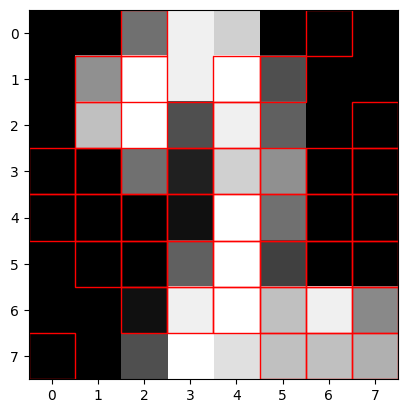

In [ ]:
show_image_with_explanation(
    df=data,
    instancia_index=instancia_df["instance_index"],
    explanation=string_to_list(instancia_df["explanation_relaxed"]),
)

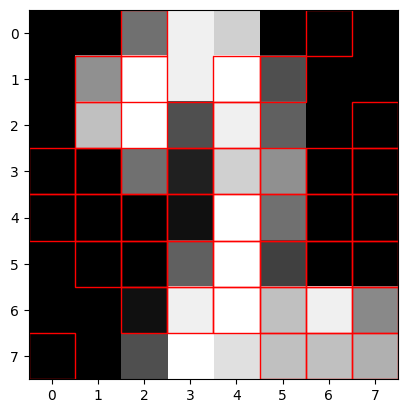

In [ ]:
show_image_with_explanation(
    df=data,
    instancia_index=instancia_df["instance_index"],
    explanation=string_to_list(instancia_df["explanation_relaxed_global"]),
)

In [ ]:
dataset_index

2